In [ ]:
import pandas as pd

In [ ]:
def df_to_pct_table(df: pd.DataFrame) -> pd.DataFrame:
  # Number of tweets by date  
  count_by_date = pd.DataFrame(df.groupby(['Date']).size()).reset_index(drop = False)
  count_by_date.columns = ['Day', 'Count_by_day']

  # Number of tweets by sentiment in each date
  count_by_sentiment = pd.DataFrame(df.groupby(['Date', 'Sentiment']).count()).reset_index(drop = False)[['Date', 'Sentiment', 'Text']]
  count_by_sentiment.columns = ['Day', 'Sentiment', 'Count_by_sentiment']
  count_by_sentiment = count_by_sentiment.sort_values('Day')

  # Percentage of tweets by sentiment in each date
  pct_by_sentiment = pd.merge(count_by_sentiment, count_by_date, on = 'Day', how = 'left')
  pct_by_sentiment['Pct_by_day'] = pct_by_sentiment['Count_by_sentiment']/pct_by_sentiment['Count_by_day']*100

  # Remove columns that aren't Positive or Negative
  pct_by_sentiment = pct_by_sentiment[~pct_by_sentiment['Sentiment'].isin(['Mixed', 'Neutrals'])].reset_index(drop = True).sort_values('Day')

  return pct_by_sentiment

### Xbox

In [ ]:
df_xbox = pd.read_excel('./stream_01082409_xbox.xlsx')

In [ ]:
df_xbox.shape

(20008, 60)

In [ ]:
df_xbox = df_xbox[['Sound Bite Text', 'Sentiment', 'Published Date (GMT+02:00) Windhoek']]
df_xbox.columns = ['Text', 'Sentiment', 'Date']
df_xbox['Date'] = pd.to_datetime(df_xbox['Date']).dt.date - pd.Timedelta(hours = 9) # Time difference between Redmond, WA, USA and Windhoek, Namibia

##### Using *default* sentiment

In [ ]:
pct_by_sentiment_xbox = df_to_pct_table(df_xbox)

In [ ]:
pct_by_sentiment_xbox.head()

,Day,Sentiment,Count_by_sentiment,Count_by_day,Pct_by_day
0,2020-08-01,Negatives,5,67,7.462687
1,2020-08-01,Positives,22,67,32.835821
2,2020-08-02,Negatives,20,295,6.779661
3,2020-08-02,Positives,96,295,32.542373
4,2020-08-03,Negatives,29,325,8.923077


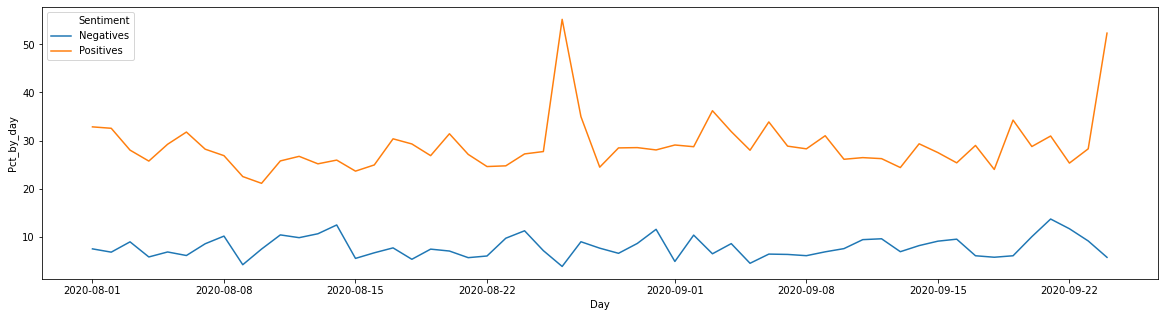

In [ ]:
fig, ax = pyplot.subplots(figsize = (20, 5))
sns.lineplot(ax = ax, x = "Day", y = "Pct_by_day", data = pct_by_sentiment_xbox, hue = 'Sentiment')

In [ ]:
pct_by_sentiment_xbox.to_csv('pct_by_sentiment_xbox.csv')

##### Using Vader sentiment

In [ ]:
df_xbox_vader = df_xbox.copy()

In [ ]:
import re
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords
english_stopwords = set(stopwords.words('english'))

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
def clean_text(text):
  text = re.sub(r'((www\.[^\s]+)|(https?://[^\s]+))', '', text) # Remove URLs
  text = re.sub(r'(@[^\s]+)', '', text) # Remove usernames
  text = re.sub(r'#([^\s]+)', r'\1', text) # Remove the # in #hashtag
  text = re.sub(r'[^A-Za-z]+', ' ', text) # Remove special characters and numbers
  text = re.sub(r'rt|fb|nflx|goog|googl|axp|aapl', '', text, flags = re.I) # Remove tickers
  text = re.sub(r'\b[a-zA-Z]\b', '', text) # Remove "single-worders"
  text = re.sub(r' [ ]+', ' ', text) # Remove extra whitespaces
  text = text.lower() # Convert text to lower-case
  return text

In [ ]:
def remove_stopwords(text):
  tokens = nltk.word_tokenize(text, 'english')
  filtered_tokens = [i for i in tokens if i not in english_stopwords]
  text = ' '.join(filtered_tokens)
  return text

In [ ]:
df_xbox_vader = df_xbox_vader[df_xbox_vader['Text'].notna()]

In [ ]:
df_xbox_vader['Text_clean'] = df_xbox_vader['Text'].map(lambda x: clean_text(x))
df_xbox_vader['Text_clean'] = df_xbox_vader['Text_clean'].map(lambda x: remove_stopwords(x))

In [ ]:
df_xbox_vader = df_xbox_vader[df_xbox_vader['Text_clean'] != '']

In [ ]:
df_xbox_vader.shape

(20003, 4)

In [ ]:
df_xbox_vader.to_csv('df_xbox_vader.csv')

In [ ]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')

/usr/local/lib/python3.6/dist-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


True

In [ ]:
sid = SentimentIntensityAnalyzer()
df_xbox_vader['Sentiment_score'] = df_xbox_vader.apply(lambda row: sid.polarity_scores(row['Text_clean'])['compound'], axis = 1)
df_xbox_vader['Sentiment'] = df_xbox_vader.apply(lambda row: 'Positives' if row['Sentiment_score'] > 0 else 'Negatives', axis = 1)

In [ ]:
# Percentage of positives
df_xbox_vader[df_xbox_vader['Sentiment'] == 'Positives'].shape[0]/df_xbox.shape[0]*100

48.18572570971612

In [ ]:
pct_by_sentiment_xbox_vader = df_to_pct_table(df_xbox_vader)

In [ ]:
pct_by_sentiment_xbox_vader.head()

,Day,Sentiment,Count_by_sentiment,Count_by_day,Pct_by_day
0,2020-08-01,Negatives,33,67,49.253731
1,2020-08-01,Positives,34,67,50.746269
2,2020-08-02,Negatives,153,295,51.864407
3,2020-08-02,Positives,142,295,48.135593
4,2020-08-03,Negatives,165,325,50.769231


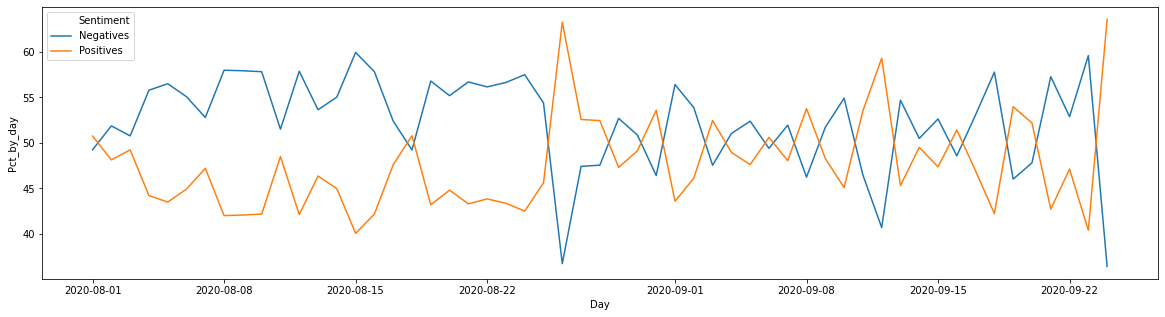

In [ ]:
fig, ax = pyplot.subplots(figsize = (20, 5))
sns.lineplot(ax = ax, x = "Day", y = "Pct_by_day", data = pct_by_sentiment_xbox_vader, hue = 'Sentiment')

In [ ]:
pct_by_sentiment_xbox_vader.to_csv('pct_by_sentiment_xbox_vader.csv')

##### Using Text Blob sentiment

In [ ]:
from textblob import TextBlob

In [ ]:
df_xbox_tb = df_xbox.copy()

In [ ]:
df_xbox_tb = df_xbox_tb[df_xbox_tb['Text'].notna()]

In [ ]:
df_xbox_tb['Text_clean'] = df_xbox_tb['Text'].map(lambda x: clean_text(x))
df_xbox_tb['Text_clean'] = df_xbox_tb['Text_clean'].map(lambda x: remove_stopwords(x))

In [ ]:
df_xbox_tb = df_xbox_tb[df_xbox_tb['Text_clean'] != '']

In [ ]:
df_xbox_tb.shape

(20003, 4)

In [ ]:
df_xbox_tb.to_csv('df_xbox_tb.csv')

In [ ]:
df_xbox_tb['Sentiment_score'] = df_xbox_tb.apply(lambda row: TextBlob(row['Text_clean']).sentiment.polarity, axis = 1)
df_xbox_tb['Sentiment'] = df_xbox_tb.apply(lambda row: 'Positives' if row['Sentiment_score'] > 0 else 'Negatives', axis = 1)

In [ ]:
# Percentage of positives
df_xbox_tb[df_xbox_tb['Sentiment'] == 'Positives'].shape[0]/df_xbox_tb.shape[0]*100

44.993251012348146

In [ ]:
pct_by_sentiment_xbox_tb = df_to_pct_table(df_xbox_tb)

In [ ]:
pct_by_sentiment_xbox_tb.head()

,Day,Sentiment,Count_by_sentiment,Count_by_day,Pct_by_day
0,2020-08-01,Negatives,37,67,55.223881
1,2020-08-01,Positives,30,67,44.776119
2,2020-08-02,Negatives,150,295,50.847458
3,2020-08-02,Positives,145,295,49.152542
4,2020-08-03,Negatives,173,325,53.230769


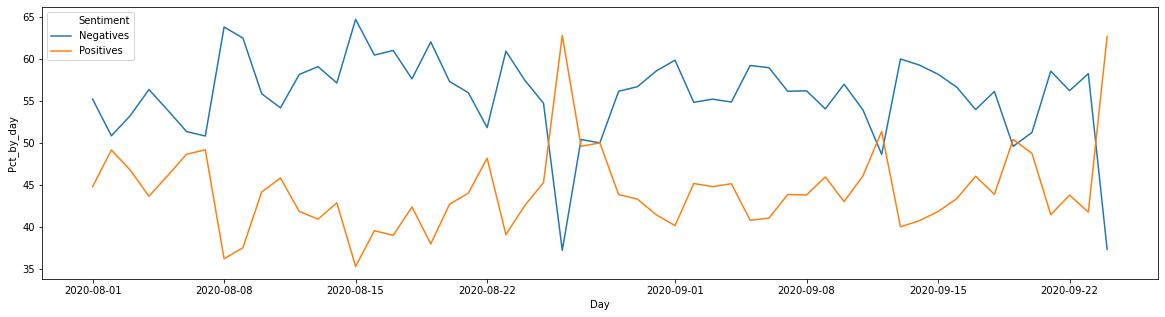

In [ ]:
fig, ax = pyplot.subplots(figsize = (20, 5))
sns.lineplot(ax = ax, x = "Day", y = "Pct_by_day", data = pct_by_sentiment_xbox_tb, hue = 'Sentiment')

In [ ]:
pct_by_sentiment_xbox_tb.to_csv('pct_by_sentiment_xbox_tb.csv')

### PlayStation

In [ ]:
df_ps = pd.read_excel('./stream_01082409_ps.xlsx')

In [ ]:
df_ps = df_ps[['Sound Bite Text', 'Sentiment', 'Published Date (GMT+02:00) Windhoek']]
df_ps.columns = ['Text', 'Sentiment', 'Date']
df_ps['Date'] = pd.to_datetime(df_ps['Date']).dt.date - pd.Timedelta(hours = 9) # Time difference between Redmond, WA, USA and Windhoek, Namibia

##### Using *default* sentiment

In [ ]:
pct_by_sentiment_ps = df_to_pct_table(df_ps)

In [ ]:
pct_by_sentiment_ps.head()

,Day,Sentiment,Count_by_sentiment,Count_by_day,Pct_by_day
0,2020-08-25,Negatives,7,66,10.606061
1,2020-08-25,Positives,25,66,37.878788
2,2020-08-26,Negatives,32,373,8.579088
3,2020-08-26,Positives,131,373,35.120643
4,2020-08-27,Negatives,26,296,8.783784


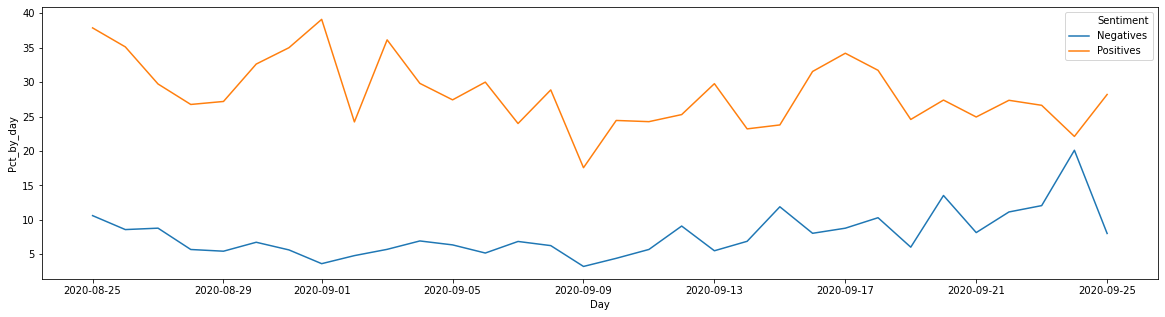

In [ ]:
fig, ax = pyplot.subplots(figsize = (20, 5))
sns.lineplot(ax = ax, x = "Day", y = "Pct_by_day", data = pct_by_sentiment_ps, hue = 'Sentiment')

In [ ]:
pct_by_sentiment_ps.to_csv('pct_by_sentiment_ps.csv')

In [ ]:
from google.colab import files
files.download('df_xbox_vader.csv') 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

##### Using Vader sentiment

In [ ]:
df_ps_vader = df_ps.copy()

In [ ]:
df_ps_vader = df_ps_vader[df_ps_vader['Text'].notna()]

In [ ]:
df_ps_vader['Text_clean'] = df_ps_vader['Text'].map(lambda x: clean_text(x))
df_ps_vader['Text_clean'] = df_ps_vader['Text_clean'].map(lambda x: remove_stopwords(x))

In [ ]:
df_ps_vader = df_ps_vader[df_ps_vader['Text_clean'] != '']

In [ ]:
df_ps_vader.shape

(13437, 4)

In [ ]:
df_ps_vader.to_csv('df_ps_vader.csv')

In [ ]:
df_ps_vader['Sentiment_score'] = df_ps_vader.apply(lambda row: sid.polarity_scores(row['Text_clean'])['compound'], axis = 1)
df_ps_vader['Sentiment'] = df_ps_vader.apply(lambda row: 'Positives' if row['Sentiment_score'] > 0 else 'Negatives', axis = 1)

In [ ]:
# Percentage of positives
df_ps_vader[df_ps_vader['Sentiment'] == 'Positives'].shape[0]/df_ps_vader.shape[0]*100

54.602961970677974

In [ ]:
pct_by_sentiment_ps_vader = df_to_pct_table(df_ps_vader)

In [ ]:
pct_by_sentiment_ps_vader.head()

,Day,Sentiment,Count_by_sentiment,Count_by_day,Pct_by_day
0,2020-08-25,Negatives,17,66,25.757576
1,2020-08-25,Positives,49,66,74.242424
2,2020-08-26,Negatives,187,373,50.134048
3,2020-08-26,Positives,186,373,49.865952
4,2020-08-27,Negatives,164,296,55.405405


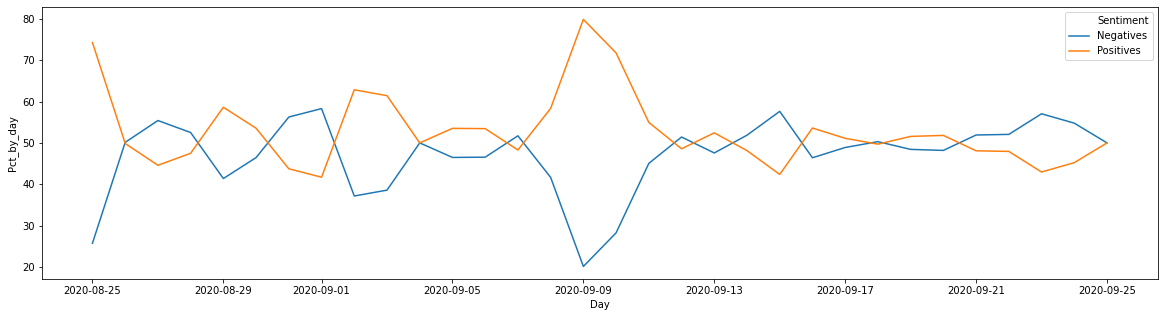

In [ ]:
fig, ax = pyplot.subplots(figsize = (20, 5))
sns.lineplot(ax = ax, x = "Day", y = "Pct_by_day", data = pct_by_sentiment_ps_vader, hue = 'Sentiment')

In [ ]:
pct_by_sentiment_ps_vader.to_csv('pct_by_sentiment_ps_vader.csv')

##### Using Text Blob sentiment

In [ ]:
df_ps_tb = df_ps.copy()

In [ ]:
df_ps_tb = df_ps_tb[df_ps_tb['Text'].notna()]

In [ ]:
df_ps_tb['Text_clean'] = df_ps_tb['Text'].map(lambda x: clean_text(x))
df_ps_tb['Text_clean'] = df_ps_tb['Text_clean'].map(lambda x: remove_stopwords(x))

In [ ]:
df_ps_tb = df_ps_tb[df_ps_tb['Text_clean'] != '']

In [ ]:
df_ps_tb.shape

(13437, 4)

In [ ]:
df_ps_tb['Sentiment_score'] = df_ps_tb.apply(lambda row: TextBlob(row['Text_clean']).sentiment.polarity, axis = 1)
df_ps_tb['Sentiment'] = df_ps_tb.apply(lambda row: 'Positives' if row['Sentiment_score'] > 0 else 'Negatives', axis = 1)

In [ ]:
# Percentage of positives
df_ps_tb[df_ps_tb['Sentiment'] == 'Positives'].shape[0]/df_ps_tb.shape[0]*100

42.62856292327156

In [ ]:
pct_by_sentiment_ps_tb = df_to_pct_table(df_ps_tb)

In [ ]:
pct_by_sentiment_ps_tb.head()

,Day,Sentiment,Count_by_sentiment,Count_by_day,Pct_by_day
0,2020-08-25,Negatives,31,66,46.969697
1,2020-08-25,Positives,35,66,53.030303
2,2020-08-26,Negatives,210,373,56.300268
3,2020-08-26,Positives,163,373,43.699732
4,2020-08-27,Negatives,167,296,56.418919


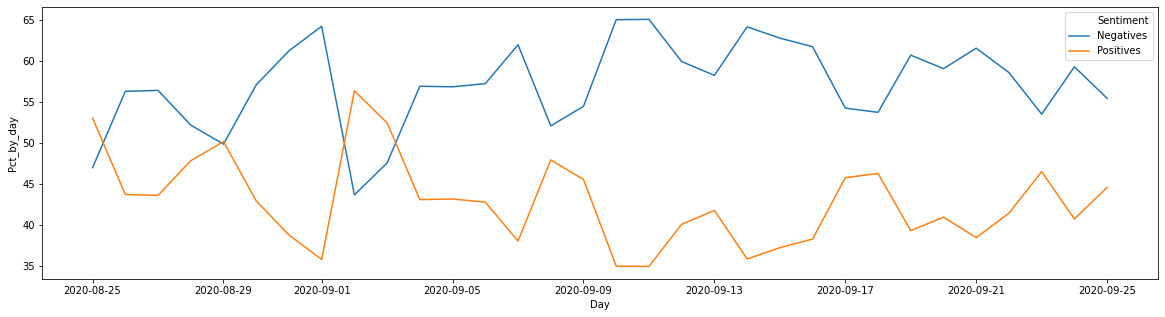

In [ ]:
fig, ax = pyplot.subplots(figsize = (20, 5))
sns.lineplot(ax = ax, x = "Day", y = "Pct_by_day", data = pct_by_sentiment_ps_tb, hue = 'Sentiment')

In [ ]:
pct_by_sentiment_ps_tb.to_csv('pct_by_sentiment_ps_tb.csv')

S

In [ ]:
xb = pd.read_csv('./xbox_subjectivity.csv')
xb['Date'] = pd.to_datetime(xb['Date']).dt.date

In [ ]:
pos = xb[xb['polarity']>0]
neg = xb[xb['polarity']<0]
xbsd_pos = pos.groupby(['Date']).subjectivity.mean()
xbsd_pos = pd.DataFrame(xbsd_pos).reset_index()
xbsd_pos.columns = ['Date', 'Subjectivity']
xbsd_neg = neg.groupby(['Date']).subjectivity.mean()
xbsd_neg = pd.DataFrame(xbsd_neg).reset_index()
xbsd_neg.columns = ['Date', 'Subjectivity']

In [ ]:
xbsd_neg.head()

,Date,Subjectivity
0,2020-08-01,0.608750
1,2020-08-02,0.497964
2,2020-08-03,0.462429
3,2020-08-04,0.496817
4,2020-08-05,0.463455


In [ ]:
xbsd_pos.to_csv('xbox_pos_subjetivity.csv')
xbsd_neg.to_csv('xbox_neg_subjetivity.csv')

In [ ]:
ps = pd.read_csv('./ps_subjectivity.csv')
ps['Date'] = pd.to_datetime(ps['Date']).dt.date

In [ ]:
pos = ps[ps['polarity']>0]
neg = ps[ps['polarity']<0]
pssd_pos = pos.groupby(['Date']).subjectivity.mean()
pssd_pos = pd.DataFrame(pssd_pos).reset_index()
pssd_pos.columns = ['Date', 'Subjectivity']
pssd_neg = neg.groupby(['Date']).subjectivity.mean()
pssd_neg = pd.DataFrame(pssd_neg).reset_index()
pssd_neg.columns = ['Date', 'Subjectivity']

In [ ]:
pssd_pos.head()

,Date,Subjectivity
0,2020-08-25,0.482825
1,2020-08-26,0.525341
2,2020-08-27,0.522114
3,2020-08-28,0.515626
4,2020-08-29,0.523025


In [ ]:
pssd_pos.to_csv('ps_pos_subjetivity.csv')
pssd_neg.to_csv('ps_neg_subjetivity.csv')

In [ ]:
df.head()

,Text,Sentiment,Date
0,RT @NieRGame: #NieR Replicant ver.1.2247448713...,Positives,2020-09-24
1,Active in the last hour: 1.) Halo 2 on #Xbox (...,Neutrals,2020-09-24
2,Post deleted by the author.,NaN,2020-09-24
3,RT @NieRGame: #NieR Replicant ver.1.2247448713...,Positives,2020-09-24
4,Im Live! Ya'll! Come join us on Twitch twitch....,Neutrals,2020-09-24


### Tweets by date

In [ ]:
count_by_date = pd.DataFrame(df.groupby(['Date']).size()).reset_index(drop = False)
count_by_date.columns = ['Day', 'Count_by_day']

NameError: ignored

In [ ]:
count_by_date.head()

,Day,Count_by_day
0,2020-08-01,67
1,2020-08-02,295
2,2020-08-03,325
3,2020-08-04,346
4,2020-08-05,308


### Tweets by date and sentiment

In [ ]:
count_by_sentiment = pd.DataFrame(df.groupby(['Date', 'Sentiment']).count()).reset_index(drop = False)
count_by_sentiment.columns = ['Day', 'Sentiment', 'Count_by_sentiment']
count_by_sentiment = count_by_sentiment.sort_values('Day')

In [ ]:
count_by_sentiment.head(10)

,Day,Sentiment,Count_by_sentiment
0,2020-08-01,Negatives,5
1,2020-08-01,Neutrals,32
2,2020-08-01,Positives,22
3,2020-08-02,Mixed,15
4,2020-08-02,Negatives,20
5,2020-08-02,Neutrals,133
6,2020-08-02,Positives,96
7,2020-08-03,Mixed,11
8,2020-08-03,Negatives,29
9,2020-08-03,Neutrals,150


### Percentage by date and sentiment

In [ ]:
pct_by_sentiment = pd.merge(count_by_sentiment, count_by_date, on = 'Day', how = 'left')
pct_by_sentiment['Pct_by_day'] = pct_by_sentiment['Count_by_sentiment']/pct_by_sentiment['Count_by_day']*100

In [ ]:
pct_by_sentiment.head()

,Day,Sentiment,Count_by_sentiment,Count_by_day,Pct_by_day
0,2020-08-01,Negatives,5,67,7.462687
1,2020-08-01,Neutrals,32,67,47.761194
2,2020-08-01,Positives,22,67,32.835821
3,2020-08-02,Mixed,15,295,5.084746
4,2020-08-02,Negatives,20,295,6.779661


### Percentage by date and sentiment (only positives)

In [ ]:
pct_posneg = pct_by_sentiment[~pct_by_sentiment['Sentiment'].isin(['Mixed', 'Neutrals'])].reset_index(drop = True).sort_values('Day')

In [ ]:
pct_posneg.head()

,Day,Sentiment,Count_by_sentiment,Count_by_day,Pct_by_day
0,2020-08-01,Negatives,5,67,7.462687
1,2020-08-01,Positives,22,67,32.835821
2,2020-08-02,Negatives,20,295,6.779661
3,2020-08-02,Positives,96,295,32.542373
4,2020-08-03,Negatives,29,325,8.923077


In [ ]:
import seaborn as sns
from matplotlib import pyplot
import matplotlib.pyplot as plt

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


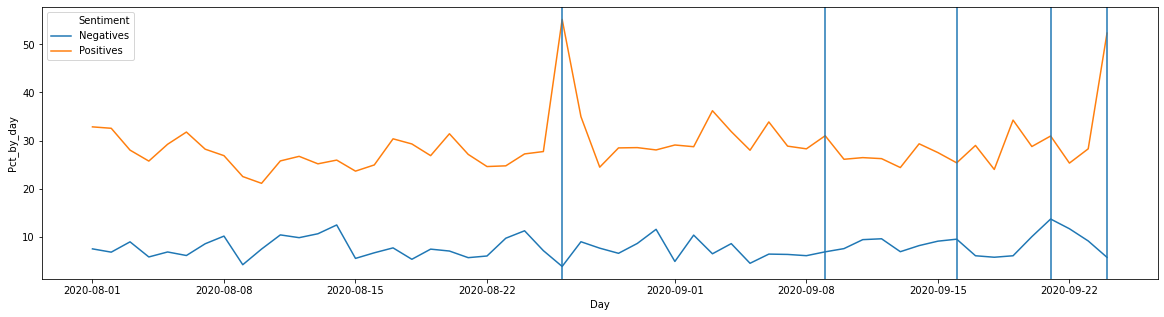

In [ ]:
# XBOX
fig, ax = pyplot.subplots(figsize = (20, 5))
sns.lineplot(ax = ax, x = "Day", y = "Pct_by_day", data = pct_posneg, hue = 'Sentiment')
plt.axvline(pd.to_datetime('2020-08-26')) # Gamepass
plt.axvline(pd.to_datetime('2020-09-24')) # Bethesda
plt.axvline(pd.to_datetime('2020-09-09')) # Precio
plt.axvline(pd.to_datetime('2020-09-16')) 
plt.axvline(pd.to_datetime('2020-09-21'))

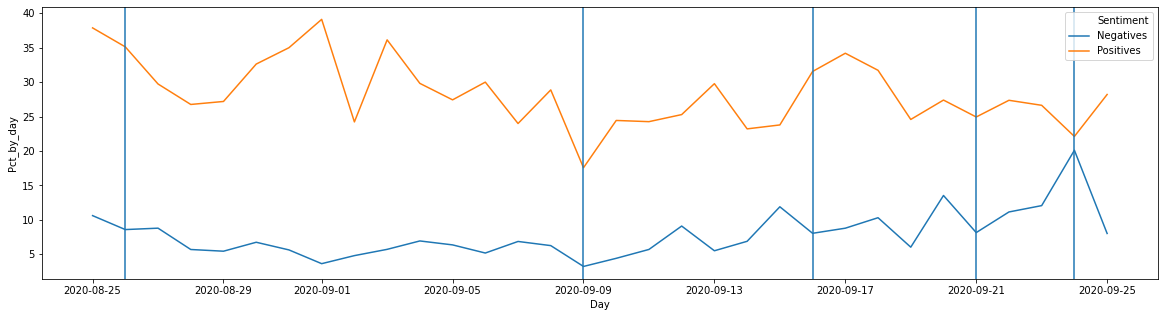

In [ ]:
# PS
fig, ax = pyplot.subplots(figsize = (20, 5))
sns.lineplot(ax = ax, x = "Day", y = "Pct_by_day", data = pct_posneg, hue = 'Sentiment')
plt.axvline(pd.to_datetime('2020-08-26'))
plt.axvline(pd.to_datetime('2020-09-24')) # Bethesda
plt.axvline(pd.to_datetime('2020-09-09')) # Precio
plt.axvline(pd.to_datetime('2020-09-16')) 
plt.axvline(pd.to_datetime('2020-09-21'))

In [ ]:
pct_posneg.to_csv('pct_posneg_ps.csv')

In [ ]:
df_all = pd.read_excel('./all.xlsx')

ConversionError: ignored

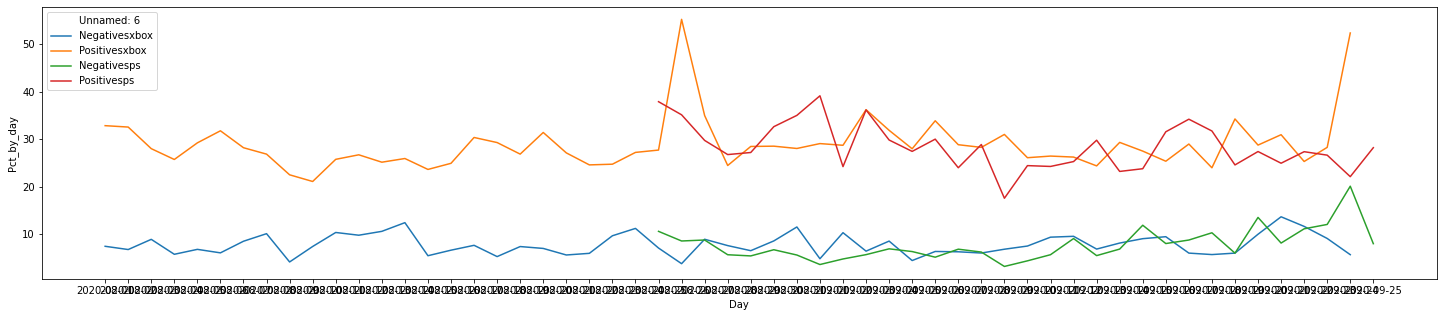

In [ ]:
fig, ax = pyplot.subplots(figsize = (25, 5))
sns.lineplot(ax = ax, x = "Day", y = "Pct_by_day", data = df_all[df_all], hue = 'Unnamed: 6')
plt.axvline(pd.to_datetime('2020-08-26'))
plt.axvline(pd.to_datetime('2020-09-24')) # Bethesda
plt.axvline(pd.to_datetime('2020-09-09')) # Precio
plt.axvline(pd.to_datetime('2020-09-16')) 
plt.axvline(pd.to_datetime('2020-09-21'))

In [ ]:
df_all.columns

Index(['Day', 'Sentiment', 'Count_by_sentiment', 'Count_by_day', 'Pct_by_day',
       'Product', 'Unnamed: 6'],
      dtype='object')

In [ ]:
df_all.head()

,Day Sentiment Count_by_seCount_by_daPct_by_day Product
0,2020-08-01 Negatives 5 67 ...
1,2020-08-01 Positives 22 67 ...
2,2020-08-02 Negatives 20 295 ...
3,2020-08-02 Positives 96 295 ...
4,2020-08-03 Negatives 29 325 ...
